In [1]:
import re
import ast
import pandas as pd
from pathlib import Path
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.utils import resample

SRC_DIR = Path('/Volumes/external_drive')
PORNHUB = [
    'Amateur ',
    'Anal',
    'Arab',
    'Asian',
    'Babe',
    'Babysitter',
    'BBW',
    'Big Ass',
    'Big Dick',
    'Big Tits',
    'Blonde',
    'Blowjob',
    'Bondage',
    'Brazilian',
    'British',
    'Brunette',
    'Casting',
    'College',
    'Cosplay',
    'Creampie',
    'Cumshot',
    'Czech',
    'Double Penetration',
    'Ebony',
    'Feet',
    'Female Orgasm',
    'Fetish',
    'Fingering',
    'Fisting',
    'French',
    'Funny',
    'Gangbang',
    'German',
    'Handjob',
    'Hardcore',
    'Indian',
    'Interracial',
    'Italian',
    'Japanese',
    'Korean',
    'Latina',
    'Lesbian',
    'Massage',
    'Masturbation',
    'Mature',
    'MILF',
    'Old/Young',
    'Orgy',
    'Pissing',
    'Public',
    'Pussy Licking',
    'Reality',
    'Red Head',
    'Romantic',
    'Rough Sex',
    'Russian',
    'SFW',
    'Small Tits',
    'Smoking',
    'Solo Female',
    'Solo Male',
    'Squirt',
    'Strap On',
    'Striptease',
    'Tattooed Women',
    'Teen',
    'Threesome',
    'Toys',
    'Transgender',
    'Vintage',
]

try:
    _df = pd.read_csv(SRC_DIR / 'image_high_res.csv')
except FileNotFoundError:
    _df = pd.read_csv('datasets/image_high_res.csv')

In [2]:
df = _df[_df['tags_list'].notnull()]
df = df[df['categories'].notnull()]

In [3]:
df['models'] = df['models'].apply(ast.literal_eval)
df['categories'] = df['categories'].apply(ast.literal_eval)
df['tags_list'] = df['tags_list'].apply(ast.literal_eval)

# Remove images with small amount of categories

<Axes: ylabel='Frequency'>

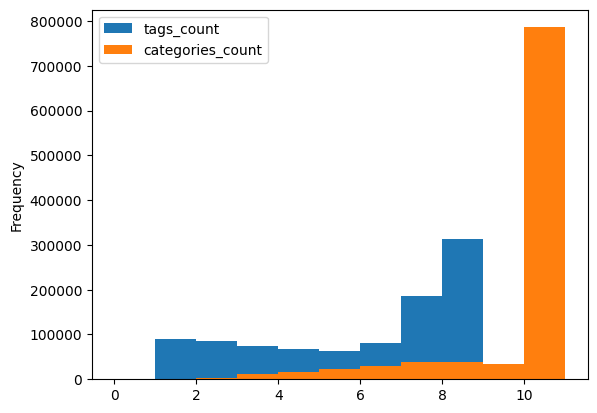

In [4]:
df['tags_count'] = df['tags_list'].apply(len)
df['categories_count'] = df['categories'].apply(len)
df['tags_count'].plot(kind='hist', bins=10, legend=True)
df['categories_count'].plot(kind='hist', bins=10, legend=True)

In [5]:
df = df[(df['categories_count'] == 10)]
df = df[(df['tags_count'] > 6)]
df.shape

(466343, 13)

# Drop categories that are too complicated

In [6]:
too_complicated = {
    'Anal Gape',
    'Ballerina',
    'Big Clit',
    'Braces',
    'Close Up',
    'FFM',
    'Face',
    'Farm',
    'Feet',
    'Goth',
    'Granny',
    'Hentai',
    'Ladyboy',
    'Old Man',
    'Pregnant',
    'Prison',
    'SS',
    'Saggy Tits',
    'Sex Doll',
    'Shemale',
    'Small Cock',
    'Twink',
    'Underwater',
    'Vintage'
}
df = df[df['categories'].apply(lambda x: all(category not in too_complicated for category in x))]

In [7]:
df.shape

(311750, 13)

# Drop context based categories

In [8]:
context_tags = {
    'Bukkake',
    'Casting',
    'Caught',
    'Cheating',
    'Family',
    'Gangbang',
    'Granny',
    'Gyno',
    'Orgy',
    'Party',
    'Spanking',
    'Swingers',
    'Tribbing',
    'Voyeur',
    'Wedding',
}

df = df[df['categories'].apply(lambda x: all(category not in context_tags for category in x))]
df.shape

(297093, 13)

# Purge nationalities from tags

In [9]:
nationality_tags_to_purge = {
    'American',
    'African',
    'Arab',
    'Argentina',
    'Australian',
    'Brazilian',
    'British',
    'Canadian',
    'Chinese',
    'Colombian',
    'Cuban',
    'Czech',
    'Dutch',
    'European',
    'Filipina',
    'French',
    'German',
    'Hungarian',
    'Indian',
    'Italian',
    'Japanese',
    'Korean',
    'Mexican',
    'Pinay',
    'Polish',
    'Russian',
    'Spanish',
    'Thai',
    'Ukrainian',
    'Venezuela',
}


def purge_nationalities(row):
    return set(row) - nationality_tags_to_purge


df['categories'] = df.categories.apply(purge_nationalities)

# Merge tags and categories

In [10]:
def merge_tags_and_categories(row):
    tags = set(row['tags_list'])
    categories = set(row['categories'])

    stripped_tags = []
    for tag in tags:
        for category in categories:
            if category in tag:
                T = re.sub(r'\s+', ' ', tag.replace(category, '').strip())
                stripped_tags.append(T)

    union = list(categories.union(stripped_tags))
    return list(set([item for item in union if item not in ['', ' ', None]]))


df['labels'] = df.apply(merge_tags_and_categories, axis=1)

In [11]:
df.columns

Index(['category', 'gallery_name', 'channel', 'models', 'categories',
       'tags_list', 'rating', 'views', 'filename', 'width', 'height',
       'tags_count', 'categories_count', 'labels'],
      dtype='object')

# Dataframe clean up

In [12]:
df['file_path'] = df['category'] + '/' + df['gallery_name'] + '/' + df['filename']
df = df.drop([
    'channel', 'models', 'categories', 'tags_list', 'rating', 'views',
    'tags_count', 'categories_count', 'category', 'gallery_name', 'filename'
], axis=1)
df.reset_index(inplace=True, drop=True)

In [13]:
df.head()

,width,height,labels,file_path
0,1280,853,"[BDSM, Cumshot, Bondage, Pussy, Cute, Hardcore...",bondage/submissive-italian-pornstar-rebecca-vo...
1,1280,853,"[BDSM, Cumshot, Bondage, Pussy, Cute, Hardcore...",bondage/submissive-italian-pornstar-rebecca-vo...
2,1280,853,"[BDSM, Cumshot, Bondage, Pussy, Cute, Hardcore...",bondage/submissive-italian-pornstar-rebecca-vo...
3,1280,853,"[BDSM, Cumshot, Bondage, Pussy, Cute, Hardcore...",bondage/submissive-italian-pornstar-rebecca-vo...
4,1280,853,"[BDSM, Cumshot, Bondage, Pussy, Cute, Hardcore...",bondage/submissive-italian-pornstar-rebecca-vo...


# Tags clean up

In [14]:
TAGS = {
    'A Cup Tits': 'Small Tits',
    'Accidental': None,
    'African': 'African',
    'Amateur': None,
    'Amateur Ass': 'Ass',
    'Amateur Bent Over': 'Bent Over',
    'Amateur Blowjob': 'Blowjob',
    'Amateur Cosplay': 'Cosplay',
    'Amateur Fuck': 'Sex',
    'Amateur Hairy': 'Hairy',
    'Amateur Interracial': 'Interracial',
    'Amateur Lingerie': 'Lingerie',
    'Amateur Panties': 'Panties',
    'Amateur Pants': None,
    'Amateur Pussy': 'Pussy',
    'Amateur Secretary': 'Secretary',
    'Amateur Selfie': 'Selfie',
    'Amateur Shaved': 'Shaved',
    'Amateur Skirt': 'Skirt',
    'Amateur Spread': 'Spread',
    'Amateur Stockings': 'Stockings',
    'Amateur Teen': 'Teen',
    'Amateur Upskirt': 'Upskirt',
    'American': 'American',
    'American Babe': ['American', 'Babe'],
    'Anal': 'Anal',
    'Anal Anal': 'Anal',
    'Anal Blowjob': ['Anal', 'Blowjob'],
    'Anal Cuckold': 'Anal',
    'Anal Dildo': ['Anal', 'Dildo', 'Sex Toys'],
    'Anal Gape': ['Anal', 'Ass', 'Asshole'],
    'Anal Pantyhose Anal': ['Anal', 'Pantyhose'],
    'Anal Pussy': ['Anal', 'Pussy'],
    'Anal Solo': ['Anal', 'Solo'],
    'Anal Strapon': ['Anal', 'Strapon'],
    'And Ass': 'Ass',
    'And Ass Latina': 'Latina',
    'And Feet': 'Feet',
    'And Fucking': 'Sex',
    'And Short Lesbian': 'Lesbian',
    'And Stockings': 'Stockings',
    'Armpit': 'Armpits',
    'Armpits': 'Armpits',
    'Asian': 'Asian',
    'Asian Ass': ['Asian', 'Ass'],
    'Asian Big': 'Asian',
    'Asian Big Tits': ['Asian', 'Big Tits'],
    'Asian Feet': ['Asian', 'Feet'],
    'Asian Fuck': ['Asian', 'Sex'],
    'Asian Licking': 'Asian',
    'Asian Open': ['Asian', ],
    'Asian Panties': ['Asian', 'Panties'],
    'Asian Pussy': ['Asian', 'Pussy'],
    'Asian Solo': ['Asian', 'Solo'],
    'Asian Spread': ['Asian', 'Spread'],
    'Asian Teen': ['Asian', 'Teen'],
    'Asian Thighs': ['Asian', 'Thighs'],
    'Asian hole': 'Asian',
    'Aside': None,
    'Ass': 'Ass',
    'Ass Bent Over': ['Ass', 'Bent Over'],
    'Ass Big Tits': ['Ass', 'Big Tits'],
    'Ass Fuck': ['Ass', 'Sex'],
    'Ass Fucking': ['Ass', 'Sex'],
    'Ass In': 'Ass',
    'Ass Licking': ['Ass Licking'],
    'Ass Pussy': ['Ass', 'Pussy'],
    'Ass Skirt': ['Ass', 'Skirt'],
    'Ass Spread': ['Ass', 'Spread'],
    'Asshole': 'Asshole',
    'Athletic': 'Fit',
    'B Cup Tits': 'Tits',
    'BBC': 'BBC',
    'BBW': 'BBW',
    'BDSM': 'BDSM',
    'Babe': 'Babe',
    'Babe Stockings': ['Babe', 'Stockings'],
    # 'Babysitter': None,
    # 'Bald': None,
    'Ball Licking': 'Ball Licking',
    'Bath': 'Bath',
    'Beach': 'Beach',
    'Beautiful': None,
    'Beautiful Pussy': 'Pussy',
    'Beautiful Stockings': 'Stockings',
    'Beautiful Upskirt': 'Upskirt',
    'Beauty': None,
    'Bent Over': 'Bent Over',
    'Bent Over Down': 'Bent Over',
    'Bent Over No': 'Bent Over',
    # 'Best': None,
    # 'Big': None,
    'Big Amateur': None,
    'Big Anal': 'Anal',
    'Big Asian': 'Asian',
    'Big Ass': ['Big Ass', 'Ass'],
    'Big Ass Ass': ['Big Ass', 'Ass'],
    'Big Ass Cumshot': ['Big Ass', 'Ass', 'Cumshot'],
    'Big Ass In': ['Big Ass', 'Ass'],
    'Big Ass In Pants': ['Big Ass', 'Ass'],
    'Big Ass s': ['Big Ass', 'Ass'],
    'Big Bent Over': 'Bent Over',
    'Big Big Cock': 'Big Cock',
    'Big Big Tits': 'Big Tits',
    'Big Black': 'Black',
    'Big Blonde': 'Blonde',
    'Big Blowjob': 'Blowjob',
    'Big Boobs': 'Big Tits',
    'Big Booty': ['Big Ass', 'Ass'],
    'Big Cock': ['Big Cock', 'Cock'],
    'Big Cock In': ['Big Cock', 'Cock'],
    'Big Cock Tight': ['Big Cock', 'Tight', 'Cock'],
    'Big Cougar': 'Cougar',
    'Big Dick': ['Big Cock', 'Cock'],
    'Big Dick In': ['Big Cock', 'Cock'],
    'Big Dick Small': ['Big Cock', 'Cock'],
    'Big Doggystyle': 'Doggy Style',
    'Big Dress': 'Dress',
    'Big Ebony': 'Ebony',
    'Big Fat': 'Fat',
    'Big Fisting': 'Fisting',
    'Big Fuck': 'Sex',
    'Big Hairy': 'Hairy',
    'Big In Yoga Pants': 'Yoga Pants',
    'Big Jeans': 'Jeans',
    'Big Latina': 'Latina',
    'Big Lingerie': 'Lingerie',
    'Big Lips': 'Lips',
    'Big Mature': 'Mature',
    'Big Mom': 'Milf',
    'Big Natural Tits': 'Big Tits',
    'Big Panties': 'Panties',
    # 'Big Pornstars': None,
    'Big Pussy': 'Pussy',
    'Big Redhead': 'Redhead',
    'Big Sex': 'Sex',
    'Big Skirt': 'Skirt',
    'Big Stockings': 'Stockings',
    'Big Teen': 'Teen',
    'Big Thong': 'Thong',
    'Big Tit': 'Big Tits',
    'Big Tit Latina': ['Big Tits', 'Latina'],
    'Big Tit Teen': ['Big Tits', 'Teen'],
    'Big Tits': 'Big Tits',
    'Big Tits And': 'Big Tits',
    'Big Tits And Ass': ['Big Tits', 'Ass'],
    'Big Tits And Latina': ['Big Tits', 'Latina'],
    'Big Tits Bikini': ['Big Tits', 'Bikini'],
    'Big Tits Cameltoe': ['Big Tits', 'Cameltoe'],
    'Big Tits Dildo': ['Big Tits', 'Dildo', 'Sex Toys'],
    'Big Tits Fuck': ['Big Tits', 'Sex'],
    'Big Tits Hairy': ['Big Tits', 'Hairy'],
    'Big Tits Legs': ['Big Tits', 'Legs'],
    'Big Tits Masturbation': ['Big Tits', 'Masturbation'],
    'Big Tits Model': 'Big Tits',
    'Big Tits Natural Tits': 'Big Tits',
    'Big Tits Pants': 'Big Tits',
    'Big Tits Pussy': ['Big Tits', 'Pussy'],
    'Big Tits Secretary': ['Big Tits', 'Secretary'],
    'Big Tits Shaved': ['Big Tits', 'Shaved'],
    'Big Tits Solo': ['Big Tits', 'Solo'],
    'Big Tits Stockings': ['Big Tits', 'Stockings'],
    'Bikini': 'Bikini',
    'Bikini Bikini': 'Bikini',
    'Bikini Solo': ['Bikini', 'Solo'],
    'Bikini Yoga Pants': ['Bikini', 'Yoga Pants'],
    'Black': 'Black',
    'Black And': 'Black',
    'Black Ass': ['Black', 'Ass'],
    'Black Close Up': 'Black',
    'Black Dick In': ['Black', 'Cock'],
    'Black Fuck': ['Black', 'Sex'],
    'Black Hairy': ['Black', 'Hairy'],
    'Black Hairy Pussy': ['Black', 'Hairy', 'Pussy'],
    'Black Lips': 'Black',
    'Black Pussy': ['Black', 'Pussy'],
    'Black Teen': ['Black', 'Teen'],
    'Black Thighs': ['Black', 'Thighs'],
    'Black Tits And': ['Black', 'Tits'],
    'Black Women': ['Black'],
    'Blindfold': None,
    'Blonde': 'Blonde',
    'Blonde Anal': ['Blonde', 'Anal'],
    'Blonde Ass': ['Blonde', 'Ass'],
    'Blonde Babe Hardcore': ['Blonde', 'Babe', 'Rough'],  ## USE HARDCORE???
    'Blonde Big Tits': ['Blonde', 'Big Tits'],
    'Blonde Cosplay': ['Blonde', 'Cosplay'],
    'Blonde Facial': ['Blonde', 'Facial'],
    'Blonde Fake Tits': ['Blonde', 'Big Tits'],
    'Blonde Fuck': ['Blonde', 'Sex'],
    'Blonde G String Blowjob': ['Blonde', 'Blowjob', 'Thong'],
    'Blonde G String Thong': ['Blonde', 'Thong'],
    'Blonde Hairy': ['Blonde', 'Hairy'],
    'Blonde High Heels': ['Blonde', 'Heels'],
    'Blonde Lingerie': ['Blonde', 'Lingerie'],
    'Blonde Masturbation': ['Blonde', 'Masturbation'],
    'Blonde Mature': ['Blonde', 'Mature'],
    'Blonde Model': ['Blonde'],
    'Blonde Outdoor': ['Blonde', 'Outdoor'],
    'Blonde Pussy': ['Blonde', 'Pussy'],
    'Blonde Secretary': ['Blonde', 'Secretary'],
    'Blonde Stockings': ['Blonde', 'Stockings'],
    'Blonde Sucking Cock': ['Blonde', 'Blowjob'],
    'Blonde Teen': ['Blonde', 'Teen'],
    'Blonde Tits': ['Blonde', 'Tits'],
    'Blonde Yoga Pants': ['Blonde', 'Yoga Pants'],
    'Blowbang': 'Blowjob',
    'Blowjob': 'Blowjob',
    'Blowjob Bent Over': ['Blowjob', 'Bent Over'],
    'Blowjob Blowjob': ['Blowjob', 'Blowjob'],
    'Blowjob Fuck': ['Blowjob', 'Sex'],
    'Blowjob Pussy': ['Blowjob', 'Pussy'],
    'Blowjob Threesome': ['Blowjob', 'Threesome'],
    'Blowjob Tits': ['Blowjob', 'Tits'],
    'Blowjob Upskirt': ['Blowjob', 'Upskirt'],
    'Bodysuit': 'Bodysuit',
    'Bondage': 'Bondage',
    'Boobs': 'Tits',
    'Boots': None,
    'Booty': 'Ass',
    'Boss And': None,
    'Boy': 'Man',
    'Brazilian': 'Brazilian',
    'Brazilian Big': 'Brazilian',
    'Brazilian Hairy': ['Brazilian', 'Hairy'],
    'Brazilian Pussy': ['Brazilian', 'Pussy'],
    'British': 'British',
    'Brunette': 'Brunette',
    'Brunette Hairy': ['Brunette', 'Hairy'],
    'Brunette Legs': ['Brunette', 'Legs'],
    'Brunette Pussy': ['Brunette', 'Pussy'],
    'Brunette Teen': ['Brunette', 'Teen'],
    'Bush': 'Hairy',
    'Busty': ['Big Tits', ],
    'Busty Asian': ['Big Tits', 'Asian'],
    'Busty Chubby': ['Big Tits', 'Chubby'],
    'Busty Fuck': ['Big Tits', 'Sex'],
    'Busty Panties': ['Big Tits', 'Panties'],
    'Busty Petite': ['Big Tits', 'Petite'],
    'Busty Redhead': ['Big Tits', 'Redhead'],
    'Busty Stockings': ['Big Tits', 'Stockings'],
    'Busty Teen': ['Big Tits', 'Teen'],
    'Butt': 'Ass',
    'Butt Plug': ['Butt plug', 'Ass'],
    'Butthole': 'Ass',
    'CFNM': None,
    'Cameltoe': 'Cameltoe',
    'Cameltoe Pussy': ['Cameltoe', 'Pussy'],
    'Centerfold': None,
    'Cheating': None,
    'Cheerleader': None,
    'Christmas': None,
    'Chubby': 'Chubby',
    'Chubby Amateur': 'Chubby',
    'Chubby Asian': ['Chubby', 'Asian'],
    'Chubby Ass': ['Chubby', 'Ass'],
    'Chubby Big Tits': ['Chubby', 'Big Tits'],
    'Chubby Black': ['Chubby', 'Black'],
    'Chubby Blonde': ['Chubby', 'Blonde'],
    'Chubby Ebony': ['Chubby', 'Ebony'],
    'Chubby Fuck': ['Chubby', 'Sex'],
    'Chubby Girl': ['Chubby', 'Girl'],
    'Chubby Hairy': ['Chubby', 'Hairy'],
    'Chubby Handjob': ['Chubby', 'Handjob'],
    'Chubby Latina': ['Chubby', 'Latina'],
    'Chubby Mature': ['Chubby', 'Mature'],
    'Chubby Panties': ['Chubby', 'Panties'],
    'Chubby Pussy': ['Chubby', 'Pussy'],
    'Chubby Spread': ['Chubby', 'Spread'],
    'Chubby Stockings': ['Chubby', 'Stockings'],
    'Chubby Teen': ['Chubby', 'Teen'],
    'Chubby hole': ['Chubby'],
    'Cleavage': None,
    'Close Up': None,
    'Close Up Licking': None,
    'Clothed': 'Clothed',
    'Cock In': 'Cock',
    'College': 'College',
    'Colombian': 'Colombian',
    'Corset': None,
    'Cosplay': 'Cosplay',
    'Cougar': 'Cougar',
    'Couple': None,
    'Cowgirl': 'Cowgirl',
    'Creampie': ['Cum', 'Pussy'],
    'Creamy': None,
    'Cuckold': None,
    'Cum': 'Cum',
    'Cum Filled': 'Cum',
    'Cum In': 'Cum',
    'Cum In Mouth': ['Cum', 'Mouth', 'Blowjob'],
    'Cum In Mouth Fuck': ['Cum', 'Mouth', 'Sex', 'Blowjob'],
    'Cum In Pussy': ['Cum', 'Pussy'],
    'Cum Inside': ['Cum', 'Pussy'],
    'Cum On': 'Cum',
    'Cum On Hairy': ['Cum', 'Hairy'],
    'Cum On Pussy': ['Cum', 'Pussy'],
    'Cum Swapping': 'Cum',
    'Cumshot': 'Cumshot',
    'Curly': 'Curly Hair',
    'Curly Hair': 'Curly Hair',
    'Curvy': 'Curvy',
    'Curvy Blonde': ['Curvy', 'Blonde'],
    'Curvy Fuck': ['Curvy', 'Sex'],
    'Curvy Solo': ['Curvy', 'Solo'],
    'Curvy Spreading': ['Curvy', 'Spread'],
    'Curvy Teen': ['Curvy', 'Teen'],
    'Cute': None,
    'Cute Blonde': 'Blonde',
    'Cute Fuck': 'Sex',
    'Cute Teen': 'Teen',
    'Czech': 'Czech',
    'D Cup Tits': 'Big Tits',
    'Dark': 'Black',
    'Dark Skin': 'Black',
    'Daughter': None,
    'Deep': None,
    'Deepthroat': 'Deepthroat',
    'Deepthroat Tits': ['Deepthroat', 'Tits'],
    'Dildo': ['Dildo', 'Sex Toys'],
    'Dildo Dildo': ['Dildo', 'Sex Toys'],
    'Dildo In': ['Dildo', 'Sex Toys'],
    'DildoD Cup Tits': ['Dildo', 'Big Tits', 'Sex Toys'],
    'Dirty': None,
    'Doctor': 'Doctor',
    'Doggy Style': 'Doggy Style',
    'Doggystyle': 'Doggy Style',
    'Doggystyle Fuck': ['Doggy Style', 'Sex'],
    'Double': 'Double Penetration',
    'Double Penetration': 'Double Penetration',
    'Down': None,
    'Dress': 'Dress',
    'Dress Babe': ['Dress', 'Babe'],
    'Dress Secretary': ['Dress', 'Secretary'],
    'Dress Skirt': ['Dress', 'Skirt'],
    'Dripping': None,
    'Dripping Wet': None,
    'Eating': None,
    'Eating Hairy': ['Pussy Licking', 'Hairy'],
    'Eating Moms': ['Pussy Licking', 'Milf'],
    'Eating Pussy': ['Pussy Licking'],
    'Eating s Pussy': ['Pussy Licking'],
    'Ebony': 'Ebony',
    'Ebony Anal': ['Ebony', 'Anal'],
    'Ebony Ass': ['Ebony', 'Ass'],
    'Ebony Big': 'Ebony',
    'Ebony Close Up': 'Ebony',
    'Ebony Eating': ['Ebony', 'Pussy Licking'],
    'Ebony Fuck': ['Ebony', 'Sex'],
    'Ebony Hairy': ['Ebony', 'Hairy'],
    'Ebony Licking': ['Ebony', 'Pussy Licking'],
    'Ebony Pants': 'Ebony',
    'Ebony Pussy': ['Ebony', 'Pussy'],
    'Ebony Spread': ['Ebony', 'Spread'],
    'Ebony Teen': ['Ebony', 'Teen'],
    'Ebony Thighs': ['Ebony', 'Thighs'],
    'Ebony Wet': 'Ebony',
    'Ebony hole': 'Ebony',
    'Emo': 'Emo',
    'Erect': None,
    # 'Erotic': '',
    # 'Erotica': '',
    'European': 'European',
    'Extremely Hairy': 'Hairy',
    'Extremely Pussy': 'Pussy',
    'F Cup Tits': 'Big Tits',
    'FFM': 'Threesome',
    'Face': None,
    'Facesitting': 'Face Sitting',
    'Facial': 'Facial',
    'Fake Tits': 'Tits',
    'Fat': 'Fat',
    'Fat Anal': ['Fat', 'Anal'],
    'Fat Asian': ['Fat', 'Asian'],
    'Fat Ass': ['Fat', 'Ass'],
    'Fat Black': ['Fat', 'Black'],
    'Fat Hairy': ['Fat', 'Hairy'],
    'Fat Latina': ['Fat', 'Latina'],
    'Fat Mature': ['Fat', 'Mature'],
    'Fat Pussy': ['Fat', 'Pussy'],
    'Fat Spread': ['Fat', 'Spread'],
    'Fat Teen': ['Fat', 'Teen'],
    'Feet': 'Feet',
    'Feet Jeans': ['Feet', 'Jeans'],
    'Feet Licking': ['Feet', 'Pussy Licking'],
    'Feet Pussy': ['Feet', 'Pussy'],
    'Female': 'Woman',
    'Femdom': None,
    'Fetish': 'Fetish',
    'Fingering': 'Fingering',
    'First Time': None,
    'First Time Fuck': 'Sex',
    'Fishnet': None,
    'Fisting': 'Fisting',
    'Fit': 'Fit',
    'Fitness': 'Fitness',
    'Flash': 'Flashing',
    'Flashing': 'Flashing',
    'Flat': 'Flat Chested',
    'Flat Chested': ['Small Tits', 'Flat Chested'],
    'Flexible': 'Flexible',
    'Footjob': None,
    'Freckles': None,
    'French': 'French',
    'Friends': None,
    'Fuck': 'Sex',
    'Fuck Anal': ['Sex', 'Anal'],
    'Fuck Bikini': ['Sex', 'Bikini'],
    'Fuck Bikini Bikini': ['Sex', 'Bikini'],
    'Fuck Blowjob': ['Sex', 'Blowjob'],
    'Fuck Cum On Tits': ['Sex', 'Cum', 'Tits'],
    'Fuck Deepthroat': ['Sex', 'Deepthroat'],
    'Fuck Fuck': 'Sex',
    'Fuck Handjob': ['Sex', 'Handjob'],
    'Fuck Hardcore': 'Sex',
    'Fuck Mature': ['Sex', 'Mature'],
    'Fuck Mature Fuck': ['Sex', 'Mature'],
    'Fuck Mom Fuck': ['Sex', 'Milf'],
    'Fuck Pussy': ['Sex', 'Pussy'],
    'Fuck Shower': ['Sex', 'Shower'],
    'Fuck Spread': ['Sex', 'Spread'],
    'Fuck Stockings': ['Sex', 'Stockings'],
    'Full Of Cum': 'Cum',
    'G String': 'Thong',
    'G String Blowjob': ['Thong', 'Blowjob'],
    'G String Pantyhose': ['Thong', 'Pantyhose'],
    'G String Teen': ['Thong', 'Teen'],
    'G String Thong': 'Thong',
    'G String Thong Thong': 'Thong',
    'Gangbang': None,
    'Gaping': None,
    'Gay': None,
    'German': 'German',
    'Ginger': 'Redhead',
    'Girl Fat Pussy': ['Girl', 'Fat', 'Pussy'],
    'Girl Fuck': ['Girl', 'Sex'],
    'Girlfriend': 'Girl',
    'Girls': 'Girl',
    'Girls Licking': 'Girl',
    'Glamour': None,
    'Glasses': 'Glasses',
    'Glasses Sucking Cock': ['Glasses', 'Blowjob'],
    'Glasses Tits': ['Glasses', 'Tits'],
    'Gloryhole': None,
    'Gorgeous': None,
    'Granny': ['Old', 'Woman', 'Mature'],
    'Great': None,
    'Group': None,
    'Group Sex': None,
    'Groupsex': None,
    'Gym': 'Gym',
    'Hair Teen': 'Teen',
    'Hairy': 'Hairy',
    'Hairy Anal': ['Hairy', 'Anal'],
    'Hairy Armpit': ['Hairy', 'Armpits'],
    'Hairy Armpits': ['Hairy', 'Armpits'],
    'Hairy Asian': ['Hairy', 'Asian'],
    'Hairy Ass': ['Hairy', 'Ass'],
    'Hairy Big Tits': ['Hairy', 'Big Tits'],
    'Hairy Blonde': ['Hairy', 'Blonde'],
    'Hairy Cameltoe': ['Hairy', 'Cameltoe'],
    'Hairy Feet': ['Hairy', 'Feet'],
    'Hairy Fuck': ['Hairy', 'Sex'],
    'Hairy Latina': ['Hairy', 'Latina'],
    'Hairy Lingerie': ['Hairy', 'Lingerie'],
    'Hairy Mature': ['Hairy', 'Mature'],
    'Hairy Pants': 'Hairy',
    'Hairy Pussy': ['Hairy', 'Pussy'],
    'Hairy Redhead': ['Hairy', 'Redhead'],
    'Hairy Spread': ['Hairy', 'Spread'],
    'Hairy Spreading': ['Hairy', 'Spread'],
    'Hairy Teen': ['Hairy', 'Teen'],
    'Hairy a': 'Hairy',
    'Hairy hole': 'Hairy',
    'Hairy s': 'Hairy',
    'Halloween': None,
    'Handjob': 'Handjob',
    'Handjob Doggystyle': ['Handjob', 'Doggy Style'],
    'Hard': None,
    'Hardcore': 'Rough',
    'Hardcore Fuck': ['Rough', 'Sex'],
    'Heels': 'Heels',
    'High Heels': 'Heels',
    'Homemade': None,
    'Horny': None,
    'Hot': None,
    'Hot Anal': 'Anal',
    'Hot Ass': 'Ass',
    'Hot Blowjob': 'Blowjob',
    'Hot Fake Tits': 'Tits',
    'Hot Mom': 'Milf',
    'Hot Solo': 'Solo',
    'Hotwife': None,
    'Housewife': None,
    'Housewives': None,
    'Huge': None,
    'Huge Anal': 'Anal',
    'Huge Dildo': ['Dildo', 'Sex Toys'],
    'Huge Hairy': 'Hairy',
    'Huge Pussy': 'Pussy',
    'Huge Tits': 'Tits',
    'Humping': 'Sex',
    'Husband Watches': None,
    'Ideal': None,
    'Ideal Panties': 'Panties',
    'Ideal Pantyhose': 'Pantyhose',
    'In Pussy': 'Pussy',
    'In Shorts': 'Shorts',
    'Indian': 'Indian',
    'Indian Solo': ['Indian', 'Solo'],
    'Innocent': None,
    'Interracial': 'Interracial',
    'Interracial Threesome': ['Interracial', 'Threesome'],
    'Italian': 'Italian',
    'Japanese': 'Japanese',
    'Japanese Hairy': ['Japanese', 'Hairy'],
    'Japanese Pussy': ['Japanese', 'Pussy'],
    'Japanese Shaved': ['Japanese', 'Shaved'],
    'Jeans': 'Jeans',
    'Juicy': None,
    'Kissing': 'Kissing',
    'Kitchen': 'Kitchen',
    'Latex': 'Latex',
    'Latina': 'Latina',
    'Latina Ass': ['Latina', 'Ass'],
    'Latina Babe': ['Latina', 'Babe'],
    'Latina Handjob': ['Latina', 'Handjob'],
    'Latina Pants': 'Latina',
    'Latina Pussy': ['Latina', 'Pussy'],
    'Latina Teen': ['Latina', 'Teen'],
    'Leather': 'Leather',
    'Leggings': ['Leggings', 'Yoga Pants'],
    'Legs': 'Legs',
    'Legs Up': 'Legs',
    'Lesbian': 'Lesbian',
    'Lesbian Anal': ['Lesbian', 'Anal'],
    'Lesbian Eating': ['Lesbian', 'Pussy Licking'],
    'Lesbian Licking': ['Lesbian', 'Pussy Licking'],
    'Lesbian Pants': 'Lesbian',
    'Lesbian Strapon': ['Lesbian', 'Strapon'],
    'Licking': None,
    'Licking Lingerie': 'Lingerie',
    'Light Skin': None,
    'Light Skin Ebony': 'Ebony',
    'Light Skin Teen': 'Teen',
    'Lingerie': 'Lingerie',
    'Lingerie Ass': ['Lingerie', 'Ass'],
    'Lingerie Cum': ['Lingerie', 'Cum'],
    'Lingerie Lingerie': ['Lingerie', 'Lingerie'],
    'Lingerie Masturbation': ['Lingerie', 'Masturbation'],
    'Lingerie Solo': ['Lingerie', 'Solo'],
    'Lingerie Stockings': ['Lingerie', 'Stockings'],
    'Lingerie Upskirt': ['Lingerie', 'Upskirt'],
    'Long': None,
    'Long High Heels': 'Heels',
    'Long Legs': 'Legs',
    'Loose': None,
    'MIL': 'Milf',
    'MILF': 'Milf',
    'MMF': 'Threesome',
    'Maid': 'Maid',
    'Massage': 'Massage',
    'Masturbating': 'Masturbation',
    'Masturbation': 'Masturbation',
    'Masturbation Bikini': ['Masturbation', 'Bikini'],
    'Masturbation Dildo': ['Masturbation', 'Dildo', 'Sex Toys'],
    'Mature': 'Mature',
    'Mature Anal': ['Mature', 'Anal'],
    'Mature Armpits': ['Mature', 'Armpits'],
    'Mature Asian': ['Mature', 'Asian'],
    'Mature Big Tits': ['Mature', 'Big Tits'],
    'Mature Black': ['Mature', 'Black'],
    'Mature Blonde': ['Mature', 'Blonde'],
    'Mature Close Up': 'Mature',
    'Mature Ebony': ['Mature', 'Ebony'],
    'Mature Fuck': ['Mature', 'Sex'],
    'Mature Hairy': ['Mature', 'Hairy'],
    'Mature Hairy s': ['Mature', 'Hairy'],
    'Mature Latina': ['Mature', 'Latina'],
    'Mature Licking': ['Mature', 'Pussy Licking'],
    'Mature Masturbation': ['Mature', 'Masturbation'],
    'Mature Open': 'Mature',
    'Mature Pants': 'Mature',
    'Mature Pussy': ['Mature', 'Pussy'],
    'Mature Redhead': ['Mature', 'Redhead'],
    'Mature Shaved': ['Mature', 'Shaved'],
    'Mature Spread': ['Mature', 'Spread'],
    'Mature Wet': 'Mature',
    'Mature Women': ['Mature', 'Woman'],
    'Mature hole': 'Mature',
    'Meaty': None,
    'Micro': None,
    'Mini': None,
    'Mini Dress': 'Dress',
    'Mini Fuck': 'Sex',
    'Mini Glasses': 'Glasses',
    'Mini High Heels': 'Heels',
    'Mini Secretary': 'Secretary',
    'Mini Skirt': 'Skirt',
    'Mini Skirt Skirt': 'Skirt',
    'Mini Stockings': 'Stockings',
    'Mirror': None,
    'Missionary': 'Missionary',
    'Model': None,
    'Mom': 'Milf',
    'Mom Fuck': ['Milf', 'Sex'],
    'Mom Interracial': ['Milf', 'Interracial'],
    'Mom Threesome': ['Milf', 'Threesome'],
    'Moms Hairy': ['Milf', 'Hairy'],
    'Moms Pussy': ['Milf', 'Pussy'],
    'Muscle': 'Fit',
    'Natural': None,
    'Natural Solo': 'Solo',
    'Natural Tits': 'Tits',
    'Natural Tits Bikini': ['Tits', 'Bikini'],
    'Natural Tits D Cup Tits': ['Tits', 'Big Tits'],
    'Naughty': None,
    'Nerd': ['Glasses', 'Nerd'],
    'Nerdy': 'Nerd',
    'Nerdy Pantyhose': ['Nerd', 'Pantyhose'],
    'Nerdy Upskirt': ['Nerd', 'Upskirt'],
    'Nice': None,
    'Nipples': 'Nipples',
    'No': None,
    'No Panties': None,
    'Non Nude': 'Non Nude',
    'Nudist': 'Nude',
    'Nun': None,
    'Nurse': 'Nurse',
    'Nurse Fuck': ['Nurse', 'Sex'],
    'Nylon': None,
    'Nylon Cameltoe': 'Cameltoe',
    'Nylon Lingerie': 'Lingerie',
    'Nylon Stockings': 'Stockings',
    'Office': 'Office',
    'Office Fuck': ['Office', 'Sex'],
    'Office Lingerie': ['Office', 'Lingerie'],
    'Office Panties': ['Office', 'Panties'],
    'Office Secretary': ['Office', 'Secretary'],
    'Office Solo': ['Office', 'Solo'],
    'Oiled': None,
    'Oiled Black': 'Black',
    'Old': 'Old',
    'Old Young': ['Old', 'Young'],
    'Older Women': 'Mature',
    'Open': None,
    'Open Legs': 'Spread',
    'Open Pussy': 'Pussy',
    'Open Teen': 'Teen',
    'Open hole': None,
    'Orgasm': 'Orgasm',
    'Outdoor': 'Outdoor',
    'Outdoor Cameltoe': ['Outdoor', 'Cameltoe'],
    'Outdoor Solo': ['Outdoor', 'Solo'],
    'PAWG': ['PAWG', 'Fat', 'White', 'Girl'],
    'PO': None,
    'POV': None,
    'Pale': 'White',
    'Panties': 'Panties',
    'Panties Lingerie': ['Panties', 'Lingerie'],
    'Panties Panties': 'Panties',
    'Panties Small Tits': ['Panties', 'Small Tits'],
    'Panties Upskirt': ['Panties', 'Upskirt'],
    'Pants': None,
    'Pants Ass': 'Ass',
    'Pants Bent Over': 'Bent Over',
    'Pants Feet': 'Feet',
    'Pants Pants': None,
    'Pants Spread': 'Spread',
    'Pantyhose': 'Pantyhose',
    'Pantyhose Panties': ['Pantyhose', 'Panties'],
    'Pantyhose Threesome': ['Pantyhose', 'Threesome'],
    'Pantyhose Tits': ['Pantyhose', 'Tits'],
    'Pantyhose Upskirt': ['Pantyhose', 'Upskirt'],
    'Pegging': ['Strapon', 'Anal', 'Sex', 'Dildo', 'Sex Toys'],
    'Perfect': None,
    'Perfect Body': None,
    'Perfect Tits And': 'Tits',
    'Petite': 'Petite',
    'Petite Big': 'Petite',
    'Petite Big Tits': ['Petite', 'Big Tits'],
    'Petite Blonde': ['Petite', 'Blonde'],
    'Petite Ebony': ['Petite', 'Ebony'],
    'Petite Facial': ['Petite', 'Facial'],
    'Petite Fuck': ['Petite', 'Sex'],
    'Petite Panties': ['Petite', 'Panties'],
    'Petite Pussy': ['Petite', 'Pussy'],
    'Petite Teen': ['Petite', 'Teen'],
    'Phat': 'Fat',
    'Pierced': 'Piercing',
    'Piercing': 'Piercing',
    'Pigtails': 'Pigtails',
    'Pink': None,
    'Pissing': 'Pissing',
    'Police': 'Uniform',
    'Pool': 'Pool',
    'Pornstar': None,
    'Pornstars': None,
    'Pretty': None,
    'Public': 'Public',
    'Puffy': None,
    'Puffy Nipples': 'Nipples',
    'Pussy': 'Pussy',
    'Pussy Anal': ['Pussy', 'Anal'],
    'Pussy Bent Over': ['Pussy', 'Bent Over'],
    'Pussy Big Tits': ['Pussy', 'Big Tits'],
    'Pussy Bikini': ['Pussy', 'Bikini'],
    'Pussy Close Up': 'Pussy',
    'Pussy Eating': ['Pussy', 'Pussy Licking'],
    'Pussy Feet': ['Pussy', 'Feet'],
    'Pussy Fuck': ['Pussy', 'Sex'],
    'Pussy Licking': ['Pussy', 'Pussy Licking'],
    'Pussy Lingerie': ['Pussy', 'Lingerie'],
    'Pussy Panties': ['Pussy', 'Panties'],
    'Pussy Pussy': ['Pussy', 'Pussy'],
    'Pussy Spread': ['Pussy', 'Spread'],
    'Reality': None,
    'Redhead': 'Redhead',
    'Redhead Anal': ['Redhead', 'Anal'],
    'Redhead Blowjob': ['Redhead', 'Blowjob'],
    'Redhead Fuck': ['Redhead', 'Sex'],
    'Redhead Pants': 'Redhead',
    'Redhead Pussy': ['Redhead', 'Pussy'],
    'Redhead Skirt': ['Redhead', 'Skirt'],
    'Redhead Teen': ['Redhead', 'Teen'],
    'Reverse': None,
    'Riding': None,
    'Round': None,
    'Russian': 'Russian',
    'Russian Anal': ['Russian', 'Anal'],
    'Russian Teen': ['Russian', 'Teen'],
    'SS Fuck': 'Sex',
    'Saggy Tits': 'Tits',
    'Sandals': 'Sandals',
    'School': 'School',
    'Schoolgirl': ['School', 'Uniform'],
    'Scissoring': 'Lesbian',
    'Secretary': 'Secretary',
    'Secretary Lingerie': ['Secretary', 'Lingerie'],
    'Seduction': None,
    'See Through': None,
    'Selfie': 'Selfie',
    'Sex': 'Sex',
    'Sexy': None,
    'Sexy Big': None,
    'Sexy Black': 'Black',
    'Sexy Model': None,
    'Sexy Solo': 'Solo',
    'Sexy Women': 'Woman',
    'Sexy s': None,
    'Shaved': 'Shaved',
    'Shaved Asian': ['Shaved', 'Asian'],
    'Shaved Bikini': ['Shaved', 'Bikini'],
    'Shaved Black': ['Shaved', 'Black'],
    'Shaved Brunette': ['Shaved', 'Brunette'],
    'Shaved Pussy': ['Shaved', 'Pussy'],
    'Shaved Shaved': ['Shaved', 'Shaved'],
    'Shaved Solo': ['Shaved', 'Solo'],
    'Shaved Teen': ['Shaved', 'Teen'],
    'Shaved Tits': ['Shaved', 'Tits'],
    'Short': None,
    'Short Hair': 'Short Hair',
    'Short Hair Blonde': ['Short Hair', 'Blonde'],
    'Short Hair Cameltoe': ['Short Hair', 'Cameltoe'],
    'Short Hair Masturbation': ['Short Hair', 'Masturbation'],
    'Short Hair Outdoor': ['Short Hair', 'Outdoor'],
    'Short High Heels': ['Short Hair', 'Heels'],
    'Short No Panties': 'Short Hair',
    'Short Skirt': ['Short Hair', 'Skirt'],
    'Short Skirt No': 'Short Hair',
    'Shorts': 'Shorts',
    'Shower': 'Shower',
    'Shower Shower': 'Shower',
    'Skinny': 'Skinny',
    'Skinny Anal': ['Skinny', 'Anal'],
    'Skinny Asian': ['Skinny', 'Asian'],
    'Skinny Ass': ['Skinny', 'Ass'],
    'Skinny Big': 'Skinny',
    'Skinny Big Tits': ['Skinny', 'Big Tits'],
    'Skinny Bikini': ['Skinny', 'Bikini'],
    'Skinny Black': ['Skinny', 'Black'],
    'Skinny Black Hairy': ['Skinny', 'Black', 'Hairy'],
    'Skinny Black Pussy': ['Skinny', 'Black', 'Pussy'],
    'Skinny Blonde': ['Skinny', 'Blonde'],
    'Skinny Blowjob': ['Skinny', 'Blowjob'],
    'Skinny Brunette': ['Skinny', 'Brunette'],
    'Skinny Creampie': ['Skinny', 'Cum', 'Pussy'],
    'Skinny Ebony': ['Skinny', 'Ebony'],
    'Skinny Feet': ['Skinny', 'Feet'],
    'Skinny Fuck': ['Skinny', 'Sex'],
    'Skinny Girl': ['Skinny', 'Girl'],
    'Skinny Girl Fat': ['Skinny', 'Girl', 'Fat'],
    'Skinny Hairy': ['Skinny', 'Hairy'],
    'Skinny Huge Tits': ['Skinny', 'Big Tits'],
    'Skinny Latina': ['Skinny', 'Latina'],
    'Skinny Mature': ['Skinny', 'Mature'],
    'Skinny Pants': 'Skinny',
    'Skinny Petite': ['Skinny', 'Petite'],
    'Skinny Pussy': ['Skinny', 'Pussy'],
    'Skinny Redhead': ['Skinny', 'Redhead'],
    'Skinny Solo': ['Skinny', 'Solo'],
    'Skinny Spread': ['Skinny', 'Spread'],
    'Skinny Teen': ['Skinny', 'Teen'],
    'Skirt': 'Skirt',
    'Skirt And': 'Skirt',
    'Skirt Pussy': ['Skirt', 'Pussy'],
    'Skirt Upskirt': ['Skirt', 'Upskirt'],
    'Slim': 'Fit',
    'Sloppy': 'Blowjob',
    'Slut': None,
    'Slutty': None,
    'Small': None,
    'Small Saggy Tits': 'Small Tits',
    'Small Tits': 'Small Tits',
    'Small Tits Big': 'Small Tits',
    'Small Tits Solo': ['Small Tits', 'Solo'],
    'Smoking': 'Smoking',
    'Smooth s': None,
    'Sneakers': None,
    'Soccer': 'Sports',
    'Socks': None,
    'Soles': None,
    'Solo': 'Solo',
    'Solo Ass': ['Solo', 'Ass'],
    'Solo Glasses': ['Solo', 'Glasses'],
    'Solo Natural Tits': ['Solo', 'Tits'],
    'Solo Panties': ['Solo', 'Panties'],
    'Solo Pussy': ['Solo', 'Pussy'],
    'Solo Stockings': ['Solo', 'Stockings'],
    'Son': None,
    'Spanish': 'Spanish',
    'Sport': 'Sports',
    'Sports': 'Sports',
    'Spread': 'Spread',
    'Spread Armpit': ['Sports', 'Armpits'],
    'Spread Legs': ['Spread', 'Legs'],
    'Spread Mature': ['Spread', 'Mature'],
    'Spread Nurse': ['Spread', 'Nurse'],
    'Spread Panties': ['Spread', 'Panties'],
    'Spreading': 'Spread',
    'Spreading Cameltoe': ['Spread', 'Cameltoe'],
    'Spreading Fuck': ['Spread', 'Sex'],
    'Spreading Pussy': ['Spread', 'Pussy'],
    'Spreading Thong': ['Spread', 'Thong'],
    'Spreading Upskirt': ['Spread', 'Upskirt'],
    'Squirt': None,
    'Squirting': None,
    'Step Brother': None,
    'Step Sister': None,
    'Stepdaughter': None,
    'Stepmom': 'Milf',
    'Stockings': 'Stockings',
    'Stockings Dress': ['Stockings', 'Dress'],
    'Stockings High Heels': ['Stockings', 'Heels'],
    'Stockings Legs': ['Stockings', 'Legs'],
    'Stockings Secretary': ['Stockings', 'Secretary'],
    'Stockings Solo': ['Stockings', 'Solo'],
    'Stockings Stockings': ['Stockings', 'Stockings'],
    'Stockings Upskirt': ['Stockings', 'Upskirt'],
    'Strapon': 'Strapon',
    'Stripper': None,
    'Sucking': None,
    'Sucking Cock': 'Blowjob',
    'Sucking Cock Blowjob': 'Blowjob',
    'Sucks Cock': 'Blowjob',
    'Summer': None,
    'Super': None,
    'Super Hot': None,
    'Super Hot Fuck': 'Sex',
    'Surprise': None,
    'Sweet': None,
    'Swimming': 'Swimming',
    'Swollen': None,
    'Tall': 'Tall',
    'Tall And Short': 'Tall',
    'Tall Big': 'Tall',
    'Tall Blonde': ['Tall', 'Blonde'],
    'Tall Brunette': ['Tall', 'Brunette'],
    'Tall Glasses': ['Tall', 'Glasses'],
    'Tall Pantyhose': ['Tall', 'Pantyhose'],
    'Tall Pussy': ['Tall', 'Pussy'],
    'Tall Skinny': ['Tall', 'Skinny'],
    'Tall Teen': ['Tall', 'Teen'],
    'Tanned': None,
    'Tattoo': 'Tattoo',
    'Tattooed': 'Tattoo',
    'Tattooed Solo': ['Tattoo', 'Solo'],
    'Teacher': 'Teacher',
    'Teen': 'Teen',
    'Teen Anal': ['Teen', 'Anal'],
    'Teen Armpit': ['Teen', 'Armpits'],
    'Teen Ass': ['Teen', 'Ass'],
    'Teen Big Tits': ['Teen', 'Big Tits'],
    'Teen Bikini': ['Teen', 'Bikini'],
    'Teen Blowjob': ['Teen', 'Blowjob'],
    'Teen Close Up': 'Teen',
    'Teen Creampie': ['Teen', 'Pussy', 'Cum'],
    'Teen Dildo': ['Teen', 'Dildo', 'Sex Toys'],
    'Teen Feet': ['Teen', 'Feet'],
    'Teen Fuck': ['Teen', 'Sex'],
    'Teen Huge Tits': ['Teen', 'Big Tits'],
    'Teen Mini': 'Teen',
    'Teen Panties': ['Teen', 'Panties'],
    'Teen Pants': 'Teen',
    'Teen Puffy': 'Teen',
    'Teen Pussy': ['Teen', 'Pussy'],
    'Teen Selfie': ['Teen', 'Selfie'],
    'Teen Solo': ['Teen', 'Solo'],
    'Teen Spread': ['Teen', 'Spread'],
    'Teen Spreading': ['Teen', 'Spread'],
    'Teen Upskirt': ['Teen', 'Upskirt'],
    'Teen Wet': 'Teen',
    'Teen hole': 'Teen',
    'TeenG String': ['Teen', 'Thong'],
    'Thai': 'Thai',
    'Thick': 'Thick',
    'Thick Black': ['Thick', 'Black'],
    'Thick High Heels': ['Thick', 'Heels'],
    'Thick Stockings': ['Thick', 'Stockings'],
    'Thick Thighs': ['Thick', 'Thighs'],
    'Thigh High': 'Thighs',
    'Thighs': 'Thighs',
    'Thighs Fuck': ['Thighs', 'Sex'],
    'Thighs Latina': ['Thighs', 'Latina'],
    'Thighs Mature': ['Thighs', 'Mature'],
    'Thighs Teen': ['Thighs', 'Teen'],
    'Thong': 'Thong',
    'Thong Fuck': ['Thong', 'Sex'],
    'Threesome': 'Threesome',
    'Threesome Stockings': ['Threesome', 'Stockings'],
    'Threesome Upskirt': ['Threesome', 'Upskirt'],
    'Tight': 'Tight',
    'Tight Asian': ['Tight', 'Asian'],
    'Tight Fuck': ['Tight', 'Sex'],
    'Tight Mature': ['Tight', 'Mature'],
    'Tight Pussy': ['Tight', 'Pussy'],
    'Tight Shaved': ['Tight', 'Shaved'],
    'Tight Teen': ['Tight', 'Teen'],
    'Tiny': None,
    'Tiny Tits': ['Small Tits', 'Flat Chested'],
    'Titfuck': 'Titjob',
    'Titjob': 'Titjob',
    'Tits': 'Tits',
    'Tits And': 'Tits',
    'Topless': ['Topless', 'Tits'],
    'Topless In': ['Topless', 'Tits'],
    'Toys': 'Sex Toys',
    'Trimmed': ['Trimmed', 'Hairy'],
    'Twins': None,
    'Ukraine': 'Ukraine',
    'Undressing': 'Undressing',
    'Uniform': 'Uniform',
    'Up': None,
    'Upskirt': 'Upskirt',
    'Upskirt Ass': ['Upskirt', 'Ass'],
    'Upskirt Babe': ['Upskirt', 'Babe'],
    'Upskirt Dress': ['Upskirt', 'Dress'],
    'Upskirt No': 'Upskirt',
    'Upskirt Panties': ['Upskirt', 'Panties'],
    'Upskirt Pussy': ['Upskirt', 'Pussy'],
    'Upskirt Skirt': ['Upskirt', 'Skirt'],
    'Upskirt Stockings': ['Upskirt', 'Stockings'],
    'UpskirtG String': ['Upskirt', 'Thong'],
    'Vagina': 'Pussy',
    'Very': None,
    'Very Hairy': 'Hairy',
    'Very Pussy': 'Pussy',
    'Vintage': None,
    'Wet': None,
    'Wet Close Up': None,
    'Wet Hairy': 'Hairy',
    'Wet Panties': 'Panties',
    'Wet Pussy': 'Pussy',
    'White': 'White',
    'White Cock': ['White', 'Cock'],
    'White Girl': ['White', 'Girl'],
    'White Hairy': ['White', 'Hairy'],
    'White Pussy': ['White', 'Pussy'],
    'Wide Hips Thighs': 'Thighs',
    'Wife': 'Woman',
    'Wife Anal': ['Woman', 'Anal'],
    'Wife Cuckold': 'Woman',
    'Worship': None,
    'Yoga': ['Yoga', 'Yoga Pants', 'Leggings', 'Fit'],
    'Yoga Pants': ['Yoga', 'Yoga Pants', 'Leggings'],
    'ed': None,
    'ed Bikini': 'Bikini',
    'ed Dildo': ['Dildo', 'Sex Toys'],
    'ed Feet': 'Feet',
    'ed High Heels': 'Heels',
    'ed Lingerie': 'Lingerie',
    'ed Mom': 'Milf',
    'ed Redhead': 'Redhead',
    'ed Solo Ass': ['Solo', 'Ass'],
    'ed Teen': 'Teen',
    'hole Close Up': None,
    'room Fuck': 'Sex',
    's Hairy Pussy': ['Hairy', 'Pussy'],
}

In [15]:
def map_tags(row):
    out = []
    for label in row:
        _mapped = TAGS.get(label, None)
        if _mapped is None:
            continue

        if isinstance(_mapped, str):
            out.append(_mapped)
        elif isinstance(_mapped, list):
            out.extend(_mapped)

    return list(set(out))


df['labels'] = df.labels.apply(map_tags)

# Purge nationalities from labels

In [16]:
def purge_nationalities(row):
    return set(row) - nationality_tags_to_purge


df['labels'] = df.labels.apply(purge_nationalities)

In [17]:
df.to_csv("full_dataframe.csv")

# Overview

In [18]:
def plot_tags_count(dataframe):
    cntr = Counter([item for sublist in dataframe['labels'] for item in sublist])
    pprint({k: v for k, v in cntr.items() if v < 2000})
    plt.figure(figsize=(25, 10))
    plt.bar(cntr.keys(), cntr.values())
    plt.xticks(rotation='vertical')
    plt.show()

In [19]:
label_counts = Counter(label for labels in df['labels'] for label in labels)

n_samples = 2000
majority_labels = {label: count for label, count in label_counts.items() if count > n_samples}
minority_labels = {label: count for label, count in label_counts.items() if count < n_samples}


def get_rows_with_label(df, label):
    return df[df['labels'].apply(lambda x: label in x)]


samples_per_label = 100
balanced_dfs = []

for label in majority_labels.keys():
    df_label = get_rows_with_label(df, label)
    df_label_resampled = resample(df_label, replace=False, n_samples=samples_per_label, random_state=42)
    balanced_dfs.append(df_label_resampled)

for i, label in enumerate(minority_labels.keys()):
    df_label = get_rows_with_label(df, label)
    df_label_resampled = resample(df_label, replace=True, n_samples=samples_per_label, random_state=42)
    balanced_dfs.append(df_label_resampled)

balanced_df = pd.concat(balanced_dfs)
balanced_df.shape

(14700, 4)

In [20]:
all_labels = set(label for labels in balanced_df['labels'] for label in labels)

one_hot_encoded = pd.DataFrame()
for label in all_labels:
    one_hot_encoded[label] = balanced_df['labels'].apply(lambda x: 1 if label in x else 0)

/var/folders/cq/qnm4dkj53rq748w0d5l1yz5h0000gn/T/ipykernel_96695/1290821390.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  one_hot_encoded[label] = balanced_df['labels'].apply(lambda x: 1 if label in x else 0)
/var/folders/cq/qnm4dkj53rq748w0d5l1yz5h0000gn/T/ipykernel_96695/1290821390.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  one_hot_encoded[label] = balanced_df['labels'].apply(lambda x: 1 if label in x else 0)
/var/folders/cq/qnm4dkj53rq748w0d5l1yz5h0000gn/T/ipykernel_96695/1290821390.py:5: PerformanceWarning: Da

In [21]:
final_df = pd.concat([balanced_df, one_hot_encoded], axis=1)

In [ ]:
final_df = final_df.drop(columns=['labels', 'width', 'height'], axis=1)
final_df.reset_index(drop=True, inplace=True)

In [ ]:
final_df.head(50)

In [ ]:
final_df.to_csv("sample_df.csv")